In [15]:
import os
import sys
from glob import glob
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from __future__ import unicode_literals
from IPython.core.display import display, HTML
from pprint import pprint 
import traceback

import radical.utils     as ru
import warnings
import itertools
import matplotlib

warnings.filterwarnings('ignore')
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)
matplotlib.use("Agg")

In [16]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.unicode'] = False
mpl.rcParams['font.family'] = 'Average'
# mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup(num_x, num_y, size_x, size_y, space_x=0.25, space_y=0.25):
    fig, axes = plt.subplots(num_x, num_y, figsize=(size_x, size_y), gridspec_kw={'wspace':space_x, 'hspace':space_y}, sharex=False, sharey=False)
    if num_x == 1 and num_y == 1:
        axes = [[axes]]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    elif (num_x == 1 and num_y>1) or (num_x>1 and num_y == 1):
        axes = [axes]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    return fig, axes

In [17]:
loc = '/home/aydins/wlms_calculator/exps/data/validation/'
cases = 4
trials = 30
fontsize=18
def parse_uids(uid):
    new_uid = int(uid.split('.')[-1])
    return new_uid
#print glob('%s/case-exp*/profile.*'%loc)

In [18]:
def extract(loc):
    df_dict = dict()
    print glob('%s/profile.*'%loc)
    for x in glob('%s/profile.*'%loc):
        json_data = ru.read_json(x)

    keys = sorted(json_data.keys())
    trials=30
    cur_trial = 1
    exp = 0
    hets = list()

    for key in keys:
        if exp==0:
            het = 0
        else:
            het = pow(2,exp)

        if het not in hets:
            hets.append(het)
            df_dict[het] = dict()

        prof = json_data[key]
        df = pd.DataFrame.from_dict(prof)
        df['core'] = df['core'].apply(parse_uids)
        df['task'] = df['task'].apply(parse_uids)
        df['perf'] = df['ops']/df['exec_time']

        df_dict[het][cur_trial] = df
        cur_trial +=1
        if cur_trial > trials:
            cur_trial = 1
            exp+=1

    return df_dict

In [19]:
def transform(dfs):
    hets = sorted(dfs.keys())
    df = pd.DataFrame(columns=['het','ttx'])
    df_err = pd.DataFrame(columns=['het','ttx'])
    result = dict()
    for het in hets:
        ttx = list()
        for t in range(1, trials+1):
            ttx.append(dfs[het][t]['end_time'].max() - dfs[het][t]['start_time'].min())
        result[het] = (np.mean(ttx), np.std(ttx))
        
    return result

In [20]:
from matplotlib import lines
#lines.lineStyles.keys()

[u'/home/aydins/wlms_calculator/exps/data/validation/case-poisson-1/profile.executor.2020.02.25.23.49.25.025871.0000.json']
[u'/home/aydins/wlms_calculator/exps/data/validation/case-poisson-2/profile.executor.2020.02.26.00.28.00.011772.0000.json']
[u'/home/aydins/wlms_calculator/exps/data/validation/case-poisson-3/profile.executor.2020.02.26.00.33.41.006613.0000.json']
[u'/home/aydins/wlms_calculator/exps/data/validation/case-poisson-4/profile.executor.2020.02.26.00.38.29.028732.0000.json']
       method         ttx
0  457.300000  457.300000
1  114.166667  114.166667
2  451.833333  451.833333
3  103.733333  103.733333


Text(0.5,0.95,u'Total execution time (poisson $\\lambda_{res}$ = 32, $\\lambda_{wl}$ = 1024)')

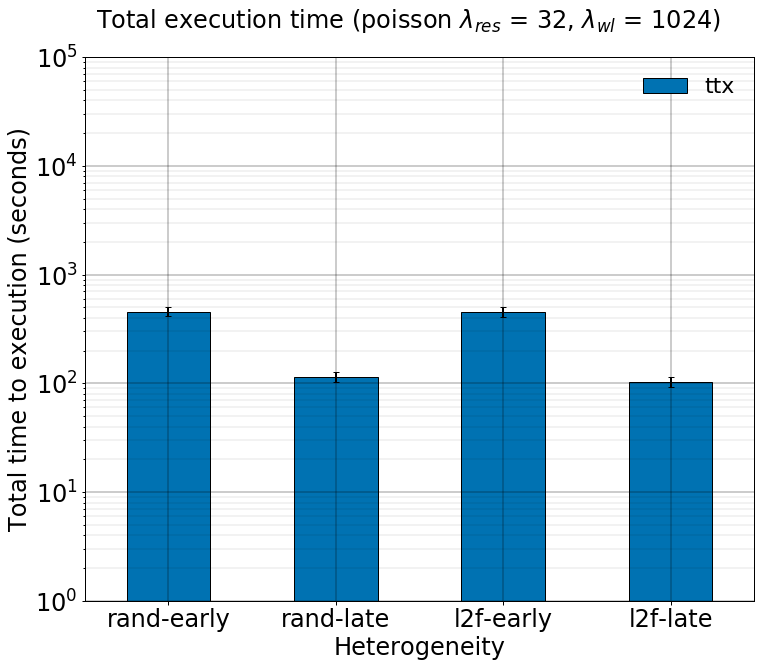

In [22]:
fig, axes = fig_setup(1,1, 12,10, 0.35,0.35)  
df = pd.DataFrame(columns=['method','ttx'])
df_err = pd.DataFrame(columns=['method','ttx'])

i=0
for case in range(1, 5):
    tmp = extract(loc+'case-exp-%s'%case)
    res = transform(tmp)
    avgs = res[0][0]
    stds = res[0][1]
    df.loc[i] = avgs
    df_err.loc[i] = stds        
    i+=1
print df

ax = df.plot(ax=axes[0][0], kind='bar', y=['ttx'], yerr=df_err)
ax.set_yscale('log',basey=10)
ax.set_xticklabels(['rand-early','rand-late','l2f-early','l2f-late'], rotation=0)
ax.set_xlabel('Heterogeneity')
ax.set_ylabel('Total time to execution (seconds)')
ax.set_ylim([10**0,10**5])

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.4', color='black')
# Customize the minor grid
ax.grid(which='minor', linestyle='-', linewidth='0.1', color='black')


title = 'Total execution time (exponential $\lambda_{res}$ = 32, $\lambda_{wl}$ = 1024)'
fig.suptitle(title, y=0.95)

In [23]:


fname = 'ttx_exp_cases.png'
fig.savefig('%s'%fname)